# **Experimenting on the entire Food Vision Model**

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *

--2021-11-08 21:59:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-08 21:59:00 (51.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

(train_data, test_data),ds_info = tfds.load(name = "food101", 
                                            split = ["train","validation"],
                                            with_info = True,
                                            shuffle_files = True,
                                            as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete68QO2N/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete68QO2N/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_1 = train_data.take(1)
class_names = ds_info.features["label"].names

**Visualizing a random image**

In [4]:

for image, label in train_1:
  print(image.shape)
  print(str(class_names[label.numpy()]))


(512, 512, 3)
cheesecake


Text(0.5, 1.0, 'cheesecake')

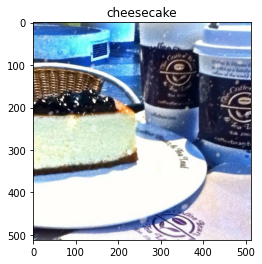

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(str(class_names[label.numpy()]))

**Pre Processing the dataset**

In [6]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label)

In [7]:
pre = preprocess_img(image,label)[0]

In [8]:
print(f"Image after preprocessing:\n {pre[:2]}...,\nShape: {pre.shape},\nDatatype: {pre.dtype}")

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


**Prefetching and using multi threading for faster data processing and fitting into the model, on both test and train data**

In [9]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
cp_path = "model_path/model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                                      monitor= "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True)

In [12]:
#!pip install tensorflow==2.4.1

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


**Using plain and basic EfficientNet model without any modifications**

In [14]:
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers.experimental.preprocessing as preprocessing


input_shape = (224,224,3)


inputs = layers.Input(shape = input_shape)


z = base_model(inputs , training = False)

z = layers.GlobalAveragePooling2D()(z)

outs = layers.Dense(len(class_names),activation="softmax")(z)

model_23 = tf.keras.Model(inputs,outs)

#base_model.trainable = True

# Freeze all layers except for the
#for layer in base_model.layers[:-10]:
#  layer.trainable = False

model_23.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer= optimizers.Adam(learning_rate=0.0001))

In [15]:
model_23.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
track64 = model_23.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                     validation_data = test_data, validation_steps = int(0.15*len(test_data)),
                     callbacks = [create_tensorboard_callback("training","step1")])

Saving TensorBoard log files to: training/step1/20211108-220834
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 351s 132ms/step - loss: 3.1041 - accuracy: 0.3705 - val_loss: 2.1395 - val_accuracy: 0.5538
Epoch 2/3
2368/2368 [==============================] - 309s 130ms/step - loss: 2.0411 - accuracy: 0.5454 - val_loss: 1.6858 - val_accuracy: 0.6094
Epoch 3/3
2368/2368 [==============================] - 310s 130ms/step - loss: 1.7516 - accuracy: 0.5861 - val_loss: 1.5082 - val_accuracy: 0.6340


Plotting loss curves

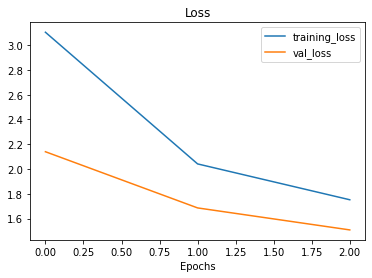

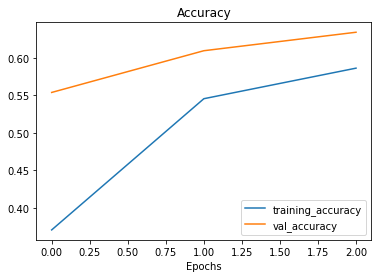

In [17]:
plot_loss_curves(track64)

**Using EfficientNet alongside augmentation layer**

In [18]:
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers.experimental.preprocessing as preprocessing


aug_layer = tf.keras.Sequential([
                                 preprocessing.RandomFlip("horizontal"),
                                 preprocessing.RandomRotation(0.2),
                                 preprocessing.RandomZoom(0.2),
                                 preprocessing.RandomHeight(0.2),
                                 preprocessing.RandomWidth(0.2),
])

input_shape = (224,224,3)


inputs = layers.Input(shape = input_shape)

z = aug_layer(inputs)

z = base_model(z , training = False)

z = layers.GlobalAveragePooling2D()(z)

outs = layers.Dense(len(class_names),activation="softmax")(z)

model_7 = tf.keras.Model(inputs,outs)

#base_model.trainable = True

# Freeze all layers except for the
#for layer in base_model.layers[:-10]:
#  layer.trainable = False

model_7.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer= optimizers.Adam(learning_rate=0.0001))


In [19]:
model_7.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
track6 = model_7.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                     validation_data = test_data, validation_steps = int(0.15*len(test_data)),
                     callbacks = [create_tensorboard_callback("training","step1")])

Saving TensorBoard log files to: training/step1/20211108-222537
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 657s 273ms/step - loss: 3.4277 - accuracy: 0.2850 - val_loss: 2.3785 - val_accuracy: 0.5029
Epoch 2/3
2368/2368 [==============================] - 446s 187ms/step - loss: 2.4680 - accuracy: 0.4499 - val_loss: 1.8933 - val_accuracy: 0.5559
Epoch 3/3
2368/2368 [==============================] - 392s 165ms/step - loss: 2.1780 - accuracy: 0.4893 - val_loss: 1.6895 - val_accuracy: 0.5882


Plotting Loss curves

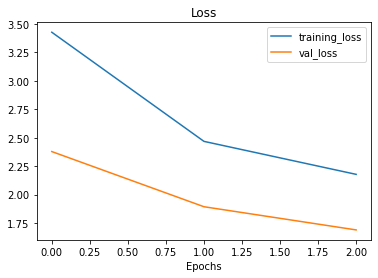

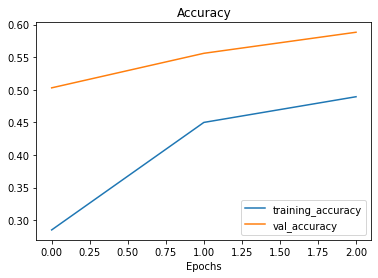

In [21]:
plot_loss_curves(track6)

**Using EfficientNet and unfreezing the last 10 layers for fine tuning**

In [22]:
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers.experimental.preprocessing as preprocessing


aug_layer = tf.keras.Sequential([
                                 preprocessing.RandomFlip("horizontal"),
                                 preprocessing.RandomRotation(0.2),
                                 preprocessing.RandomZoom(0.2),
                                 preprocessing.RandomHeight(0.2),
                                 preprocessing.RandomWidth(0.2),
])

input_shape = (224,224,3)


inputs = layers.Input(shape = input_shape)



z = base_model(inputs , training = False)

z = layers.GlobalAveragePooling2D()(z)

outs = layers.Dense(len(class_names),activation="softmax")(z)

model_4 = tf.keras.Model(inputs,outs)

base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

model_4.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer= optimizers.Adam(learning_rate=0.0001))


In [23]:
model_4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
_________________________________________________________________


In [24]:
track1 = model_4.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                     validation_data = test_data, validation_steps = int(0.15*len(test_data)),
                     callbacks = [create_tensorboard_callback("training","step1")])

Saving TensorBoard log files to: training/step1/20211108-225106
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 346s 142ms/step - loss: 2.0020 - accuracy: 0.5047 - val_loss: 1.2912 - val_accuracy: 0.6517
Epoch 2/3
2368/2368 [==============================] - 336s 141ms/step - loss: 1.3643 - accuracy: 0.6460 - val_loss: 1.1358 - val_accuracy: 0.6931
Epoch 3/3
2368/2368 [==============================] - 336s 141ms/step - loss: 1.1877 - accuracy: 0.6877 - val_loss: 1.0632 - val_accuracy: 0.7116


Plotting loss curves

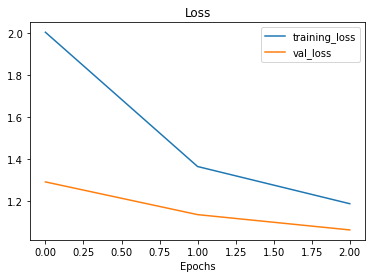

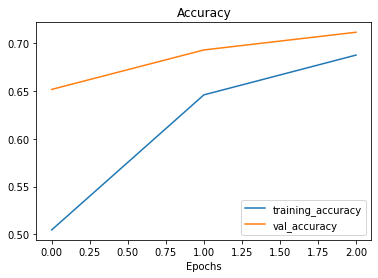

In [25]:
plot_loss_curves(track1)